In [26]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.viz import show_images, label_violinplot
from plume_learn.analyzer.plume_utils import remove_all_0_plume
from plume_learn.analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Plume data

### 1.1 load experiment conditions

In [22]:
df_condition = pd.read_excel('../data/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[[27, 34, 35, 36, 37, 38, 39, 40], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition.replace('700 (heater N)', 700, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)
df_condition.sample(5)

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
34,YG063,100.0,700,1.6,5.0
36,YG065,100.0,700,1.6,5.0
40,YG069,100.0,700,1.6,6.6
39,YG068,100.0,700,1.6,5.0
38,YG067,100.0,700,1.6,5.0


### 1.2 load metrics for every plume frame

In [34]:
growth_names = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069']

df_frame_metrics = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../large_files/SRO_plume_metrics/{key}*metrics.csv')[0]
    # print(file)
    df = pd.read_csv(file, index_col=0)
    df['Threshold'].astype(str)
    df = df[df['Threshold']=='200']
    df = remove_all_0_plume(df.reset_index(), metric='Area', viz=False)
    df_frame_metrics.append(df)
    
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics['time_index'] = df_frame_metrics['time_index'] * 500e-3 # convert ns to ms
df_frame_metrics.rename(columns={'time_index': 'Time (µs)'}, inplace=True)
df_frame_metrics.rename(columns={'plume_index': 'Plume Index'}, inplace=True)
df_frame_metrics.rename(columns={'Area': 'Area (a.u.)'}, inplace=True)
df_frame_metrics.rename(columns={'Distance': 'Distance (m)'}, inplace=True)
df_frame_metrics.rename(columns={'Velocity': 'Velocity (m/s)'}, inplace=True)

df_frame_metrics_target = df_frame_metrics[df_frame_metrics['Growth'].isin(growth_names)]
df_frame_metrics_target.sample(5)

,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Growth
144485,164,50.5,215,0.0,0.0,200,YG065
285746,127,25.0,214,0.0,0.0,200,YG068
278614,71,43.0,210,0.0,0.0,200,YG068
227480,46,12.0,206,0.0,0.0,200,YG067
157969,272,8.5,203,0.0,7.0,200,YG065


### 1.3 calculate max area and incident velocity

In [41]:
# analyze the max area
# df_frame_metrics_selected = df_frame_metrics[df_frame_metrics['Threshold']=='flexible']
idx = df_frame_metrics.groupby(['Growth', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Growth', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)
# df_max_area.sample(8)

# analyze plume Velocity that can be tracked before landing on the substrate
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 150) & (df_frame_metrics['Distance (m)'] <= 180)]
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Growth', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity': 'incident_Velocity'}, inplace=True)
# incident_Velocity.sample(8)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Growth', 'Plume Index'])
# df_plume_metrics.sample(8)

df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(growth_names)]
df_plume_metrics_target.sample(5)

,Growth,Plume Index,Time at Max Area (µs),Max Area (a.u.),Velocity (m/s)
1106,YG065,144,3.0,17680.0,44000000.0
2325,YG068,241,3.0,15607.0,46000000.0
1799,YG067,76,3.0,15601.0,44000000.0
2550,YG069,86,3.0,16318.0,46000000.0
2623,YG069,161,3.0,16434.0,46000000.0


## 2. Introduction to Plume Dynamics Analysis

### 2.1 Visualize Plume with Time

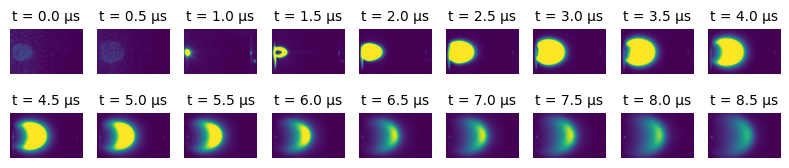

In [37]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
plumes = plume_ds.load_plumes('1-SrRuO3')
sample_frames = plumes[0][0:18]
labels = np.arange(len(sample_frames))*500e-3
labels = [f't = {l:.1f} µs' for l in labels]
fig, axes = layout_fig(18, mod=9, figsize=(8, 2), layout='tight')
show_images(sample_frames, labels=labels, img_per_row=9, title=None, fig=fig, axes=axes, label_size=10)
plt.show()

### 2.2 Visualize Plume Area and Plume Velocity

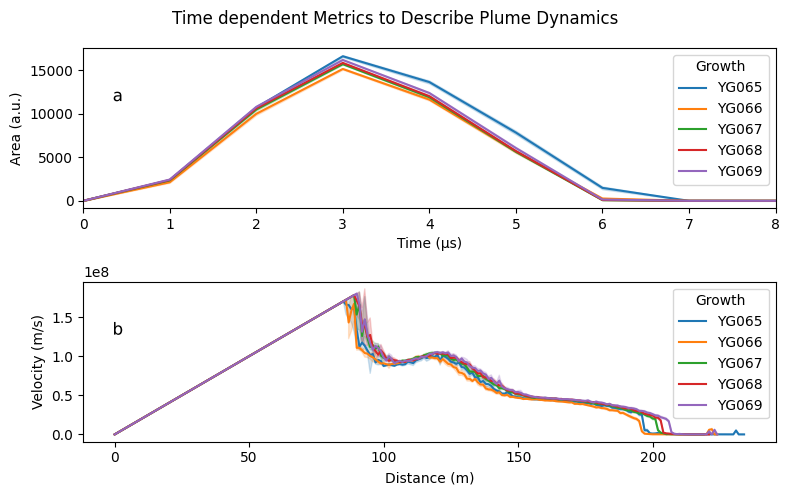

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
df_filtered = df_frame_metrics_target[df_frame_metrics_target['Time (µs)'].isin(range(0, 9))]
lineplot = sns.lineplot(x="Time (µs)", y="Area (a.u.)", hue='Growth', data=df_filtered, ax=axes[0])
axes[0].set_xlim(0, 8)
labelfigs(axes=axes[0], number=0, size=12, style='bw', inset_fraction=(0.3, 0.05))

lineplot = sns.lineplot(x="Distance (m)", y="Velocity (m/s)", hue='Growth', data=df_frame_metrics_target, ax=axes[1])
labelfigs(axes=axes[1], number=1, size=12, style='bw', inset_fraction=(0.3, 0.05))

plt.suptitle('Time dependent Metrics to Describe Plume Dynamics')
plt.tight_layout()
plt.show()

### 2.3 Violin Plot of Plume Max Area and Incident Velocity Statics

C:\Users\yig319\AppData\Local\Temp\ipykernel_37456\1014634506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Growth', y='Max Area (a.u.)', data=df_plume_metrics_target, width=0.9, ax=axes[0], palette='deep')


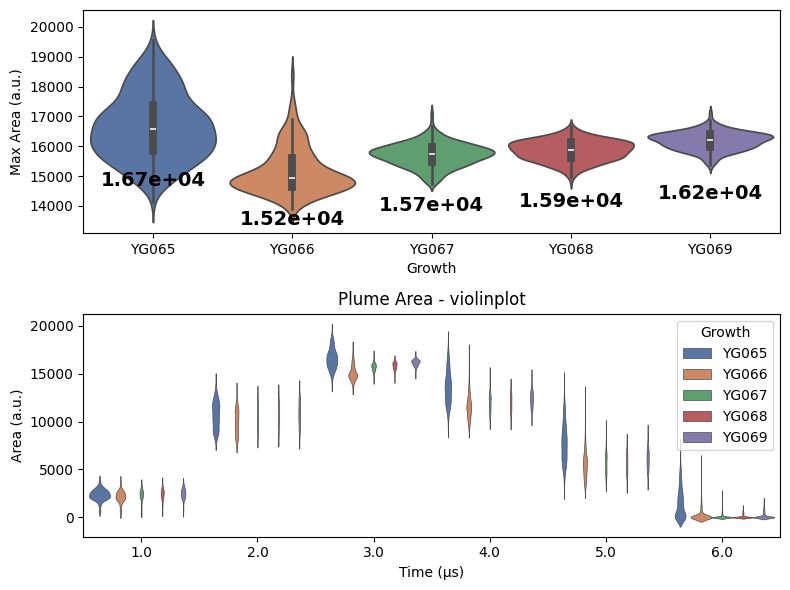

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sns.violinplot(x='Growth', y='Max Area (a.u.)', data=df_plume_metrics_target, width=0.9, ax=axes[0], palette='deep')
mean_max_area = df_plume_metrics_target.groupby('Growth')['Max Area (a.u.)'].mean()
label_violinplot(axes[0], mean_max_area, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})

df_filtered = df_frame_metrics_target[df_frame_metrics_target['Time (µs)'].isin(range(1, 7))]
sns.violinplot(x='Time (µs)', y='Area (a.u.)', hue='Growth', data=df_filtered, inner=None, width=0.9, linewidth=0.5, palette='deep')
axes[1].set_title('Plume Area - violinplot')
plt.tight_layout()
plt.show()